In [2]:
import glob
import cv2
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [3]:
def encoder(input_img):
    #encoder
    #input = 181 x 210 x 3 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #181 x 210 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [58]:
allfile=glob.glob('./data/*/*.png')
x_data=[]
y_data=[]
t=[]
label_dict = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9', 10:'a', 11:'b', 12:'c',
              13:'d', 14:'e', 15:'f', 16:'g', 17:'h', 18:'i', 19:'j', 20:'k', 21:'l', 22:'m', 23:'n', 24:'o', 25:'p',26:'q',
              27:'r', 28:'s', 29:'t', 30:'u', 31:'v', 32:'w', 33:'x', 34:'y', 35:'z'}

In [59]:
label_dict = {v: k for k, v in label_dict.items()}
for i in allfile:
    folder_name=i.split('/')[-2]
    img = cv2.imread(i,cv2.IMREAD_COLOR)
    t.append(np.shape(img))
    imge=cv2.resize(img, (600,600))
    x_data.append(imge)
    y_data.append(label_dict[folder_name])

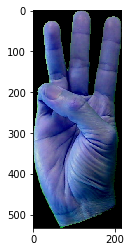

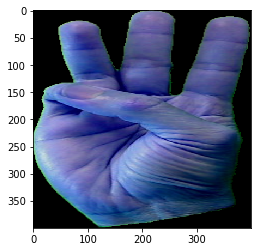

In [77]:
img = cv2.imread(allfile[200])
plt.imshow(img)
plt.show()
imge=cv2.resize(img, (400,400))
plt.imshow(imge)
plt.show()

In [56]:
a=[]
b=[]
for i in t:
    a=np.append(a,i[0])
    b=np.append(b,i[1])
print(np.max(a),np.max(b))
b

660.0 590.0


array([246., 261., 262., ..., 383., 449., 354.])

In [51]:
print(np.shape(x_data),np.shape(y_data))

(2004, 300, 300, 3) (2004,)


In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_data,
                                                y_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [14]:
print(np.shape(x_test))

(56, 180, 180, 3)


In [15]:
batch_size = 20
epochs = 1
inChannel = 3
x, y = 180,180 
input_img = Input(shape=(x,y,inChannel))
print(input_img.shape)
num_classes = 36

(?, 180, 180, 3)


In [16]:
train_data = np.reshape(x_train,(-1, 180,180,3))
train_data = train_data / np.max(train_data)

test_data = np.reshape(x_test,(-1, 180,180,3))
test_data = train_data / np.max(test_data)


In [17]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)


In [18]:
print(np.shape(train_X),np.shape(valid_X))


(179, 180, 180, 3) (45, 180, 180, 3)


In [86]:
train_label = to_categorical(y_train, num_classes=36)
test_label = to_categorical(testY, num_classes=36)

In [14]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [15]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 90, 90, 64)        1849

In [16]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Train on 1603 samples, validate on 401 samples
Epoch 1/1
1603/1603 [==============================] - 691s 431ms/step - loss: 0.0384 - val_loss: 0.5281
